In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import patsy
import pandas as pd
import numpy as np
from statsmodels.discrete.discrete_model import Logit

import matplotlib.pyplot as plt

os.makedirs("raw_plots",exist_ok=True)
os.makedirs("source_data",exist_ok=True)

# Extended Figure 4a

### Panels generated in Figure1d notebook (https://github.com/bbglab/boostdm-analyses/blob/master/Figure1/display_panels_Figure1.ipynb) 

# Extended Figure 4b

### Panels generated in Figure1d notebook (https://github.com/bbglab/boostdm-analyses/blob/master/Figure1/display_panels_Figure1.ipynb) 

# Extended Figure 4c

In [3]:
fn = os.path.join(os.environ['PATH_SOURCE_DATA'], 'extended-figure4-source-data', 'bench_gnomad_AF.txt')
df = pd.read_csv(fn, sep='\t', low_memory=False)
df.drop(columns=['boostDM_score'], inplace=True)

In [4]:
df['AF_bin'] = df['FUNC_SCORE'].apply(lambda x: 1*(0<=x<1e-5) + 2*(1e-5<=x<1e-4) + 3*(1e-4<=x<1e-3) + 4*(1e-3<=x))
df = df[df['FUNC_SCORE'] > 0]  # keep non-zero frequencies
df['logAF'] = df['FUNC_SCORE'].apply(lambda x: -np.log10(x))

In [5]:
def logit(gene, ttype):
    
    dg = df[(df['gene'] == gene) & ((df['csqn_type_missense'] == 1) | (df['csqn_type_nonsense'] == 1))].copy()
    dg[f'boostDM_score_{ttype}_bin'] = dg[f'boostDM_score_{ttype}'].apply(lambda x: int(x >= 0.5))
    y, X = patsy.dmatrices(f'boostDM_score_{ttype}_bin ~ logAF', dg, return_type='matrix')
    logit = Logit(y, X)
    res = logit.fit_regularized(method='l1', disp=0)
    return res._results.params, res._results.pvalues


def plot_gnomad_bar(gene, ttype, plot=False):
    
    dg = df[(df['gene'] == gene) & ((df['csqn_type_missense'] == 1) | (df['csqn_type_nonsense'] == 1))]
    dg = dg.drop_duplicates(subset=['chr', 'pos', 'alt', 'aachange'], keep='first')
    x = dg['AF_bin'].values + np.random.normal(0, 0.03, size=dg['AF_bin'].shape[0])
    y = dg[f'boostDM_score_{ttype}'].values
    
    # logistic regression
    params, pvalues = logit(gene, ttype)
    
    # boostDM bins
    bins = []
    for b in [1,2,3,4]:
        bins.append(dg[dg['AF_bin'] == b][f'boostDM_score_{ttype}'].values)
    
    driver_bin = list(map(lambda x: sum(x >= 0.5) / len(x), bins))
    passenger_bin = list(map(lambda x: sum(x < 0.5) / len(x), bins))
    
    if plot:
        fig, ax = plt.subplots()
        ax.bar([1,2,3,4], driver_bin, color='#ac0f0f', width=0.5, alpha=0.7)
        ax.bar([1,2,3,4], passenger_bin, bottom=driver_bin, width=0.5, color='#636363', alpha=0.5)
        ax.set_xticks([1,2,3,4])
        xticklabels = ['$\leq 10^{-5}$', '$10^{-5}-10^{-4}$', '$10^{-4}-10^{-3}$', '$\geq 10^{-3}$']

        ax.set_xticklabels(xticklabels)
        ax.set_title(f'{gene}: {ttype}\nLOR={params[1]:.3f}: pval={pvalues[1]:.3f}')
        ax.set_ylabel('boostDM')
        ax.set_xlabel('frequency bins (gnomAD)')
        ax.set_ylim(-0.1, 1.19)
        for b in [1,2,3,4]:
            ax.annotate(f'N={int(driver_bin[b-1] * len(bins[b-1]))}/{len(bins[b-1])}', (b-0.2, 1.1))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        plt.savefig(f'./raw_plots/{gene}.{ttype}.gnomad.bar.png', dpi=300, bbox_inches='tight')
        plt.show()

    return params[1], pvalues[1], len(x)

In [6]:
# individual plots and logistic regressions gene-wise

res = {}
boostdm_scores = [c for c in df.columns if c.startswith('boostDM_score')]
for s in boostdm_scores:
    dg = df[~df[s].isnull()]
    res[s] = dg['gene'].unique().tolist()

logoddsratios = []
pvalues = []
sizes = []
labels = []

for score, genes in tqdm(res.items()):
    for g in genes:
        ttype = '_'.join(score.split('_')[2:])
        try:
            lor, pval, n = plot_gnomad_bar(g, ttype)
            if abs(lor) < 5:
                logoddsratios.append(lor)
                pvalues.append(pval)
                sizes.append(n)
                labels.append(f'{g} ({ttype})')
        except Exception as e:
            pass

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [02:20<00:00,  3.80s/it]


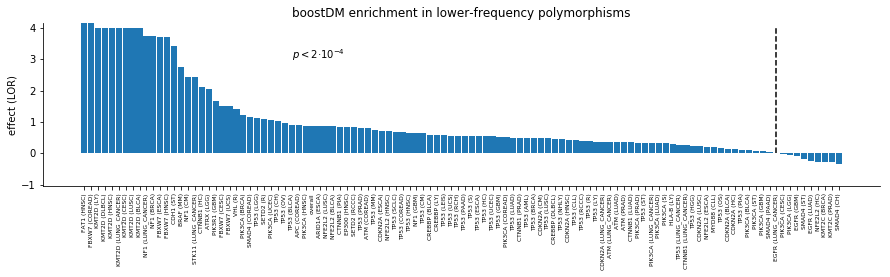

In [7]:
figsize = (15,3)
fig, ax = plt.subplots(figsize=figsize)

sortindex = np.argsort(logoddsratios + [0.86])[::-1]
lor = np.array(logoddsratios + [0.86])[sortindex]
lab = np.array(labels + ['overall'])[sortindex]

ax.bar(range(len(lor)), lor, width=0.9)

ax.text(30, 3, '$p<2·10^{-4}$')

ax.vlines(100, 0, 4, linestyles='--')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(range(len(lor)))
ax.set_xticklabels(lab, fontsize=6, rotation=90)
ax.set_ylabel('boostDM model')
ax.set_ylabel('effect (LOR)')
ax.set_ylim(-1.05, 4.15)
ax.set_title('boostDM enrichment in lower-frequency polymorphisms')
plt.savefig('./raw_plots/bar.effect.gnomad.svg', dpi=300, bbox_inches='tight')
plt.show()